# Speech Emotion Recognition 

## Executive Summary

As emotions play a vital role in communication, the detection and analysis of the same is of vital mental importance in today’s digital world of remote communication.  Human emotions can be detected and analysed in numerous way such as audio properties, facial expression, body gesture.



One application for audio speech emotion recognition on business enterprises would be on call centres.

For an application like call centres, the business objective is to primarily to forecast individuals' behavioral tendencies, towards achieving the ultimate analysis of the true behavioural and characteristics of the caller.

This increases customer retention, improving call handling efficiency, in-depth understanding of the emotions of a caller will lower average call length and increase efficiency along with customer experience, the ability to differentiate between happy, neutral, uncertain, disappointed or displeased moods, eliminating root causes of long call, measuring customers' emotions in each call can lead to a  better understanding of their needs regarding satisfaction, to be able to react immediately to any particular situation with the analysis of the emotions of any particular customer. Business issues, competitive intelligence and marketing campaigns can also be identified.

It improves the functionality of call centres, providing targeted coaching and also gives health care support for elderly people at emergency call centers. It could be beneficial for call centers of call urgency and consequent call ranking and redistribution is based on emotion recognition in speech, giving greater priority to calls featuring emotions such as fear, anger and sadness, and less priority to calls featuring neutral speech and happiness.


With the insights gathered from using “The Ryerson Audio-Visual Database of Emotional Speech and Song” (RAVDESS) & "Crowd Sourced Emotional Multimodal Actors Dataset" (CREMA-D) datasets, the approach of using Speech Emotion Recognition (SER) system is to base on the features extracted and obtained by Mel-frequency cepstral coefficient (MFCC) spectrograms where the frequency can match more closely to what the human ear can hear.

### Problem Statement

The objective of this project is to be able to classify and predict emotions via speech reconginition with a reasonable accuracy in order to improve the value of customer relationships, the quality of interactions between agents and customers as well as it's functionality as an actionable business intelligence tool for call centres.



### Libraries imports

In [1]:
#pip install librosa soundfile numpy sklearn pyaudio

In [2]:
#pip install --upgrade tensorflow

In [3]:
# Import libraries 
import librosa
import librosa.display
import soundfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd

import seaborn as sns
import scipy.io

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import IPython.display as ipd  # To play sound in the notebook
import os, glob, pickle
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Retrieve Audio dataset from File System

In [4]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

RAV = "../datasets/RAVDESS/audio_speech_actors_01-24/"
CREMA = "../datasets/AudioWAV/"

# Run one example 
dir_list = os.listdir(RAV+"Actor_01/")
dir_list[0:5]

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-01-01-02-01-01.wav',
 '03-01-01-01-02-02-01.wav',
 '03-01-02-01-01-01-01.wav']

### (RAVDESS) Dataset

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS),and it is free to download. This dataset has 7356 files rated by 247 individuals 10 times on emotional validity, intensity, and genuineness. here the Speech files of all actors (01-24) will be used and the files are available under path ../datasets/RAVDESS. It contains 1440 files: 60 trials per actor x 24 actors = 1440. 
Filename identifiers:
<ol>
<li>Modality (01 = full-AV, 02 = video-only, 03 = audio-only).</li>
<li>Vocal channel (01 = speech, 02 = song).</li>
<li>Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).</li>
<li>Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.</li>
<li>Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").</li>
<li>Repetition (01 = 1st repetition, 02 = 2nd repetition)..</li>
<li>Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).</li>
</ol>

In [5]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
#loop to get all actor's sound files path
#print("actor folder:"+i)
for i in dir_list:
    fname = os.listdir(RAV + i)
    #to get all actor's relative file path
    #print("relative path for "+i+": "+RAV+i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
female_surprise     96
male_disgust        96
female_disgust      96
male_happy          96
male_angry          96
female_fear         96
female_sad          96
male_fear           96
male_surprise       96
male_sad            96
female_angry        96
female_happy        96
Name: labels, dtype: int64

### (CREMA-D) Dataset

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [6]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [7]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_sad          671
male_happy        671
male_disgust      671
male_fear         671
male_angry        671
female_fear       600
female_disgust    600
female_sad        600
female_angry      600
female_happy      600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

#### Merging all collected audio data

In [8]:
df = pd.concat([RAV_df, CREMA_df], axis = 0)
print(df.labels.value_counts())

male_sad           767
male_happy         767
male_disgust       767
male_fear          767
male_angry         767
male_neutral       719
female_fear        696
female_disgust     696
female_sad         696
female_angry       696
female_happy       696
female_neutral     656
female_surprise     96
male_surprise       96
Name: labels, dtype: int64


## Data statistics by emotion and gender

### Waveform view for Different Emotions

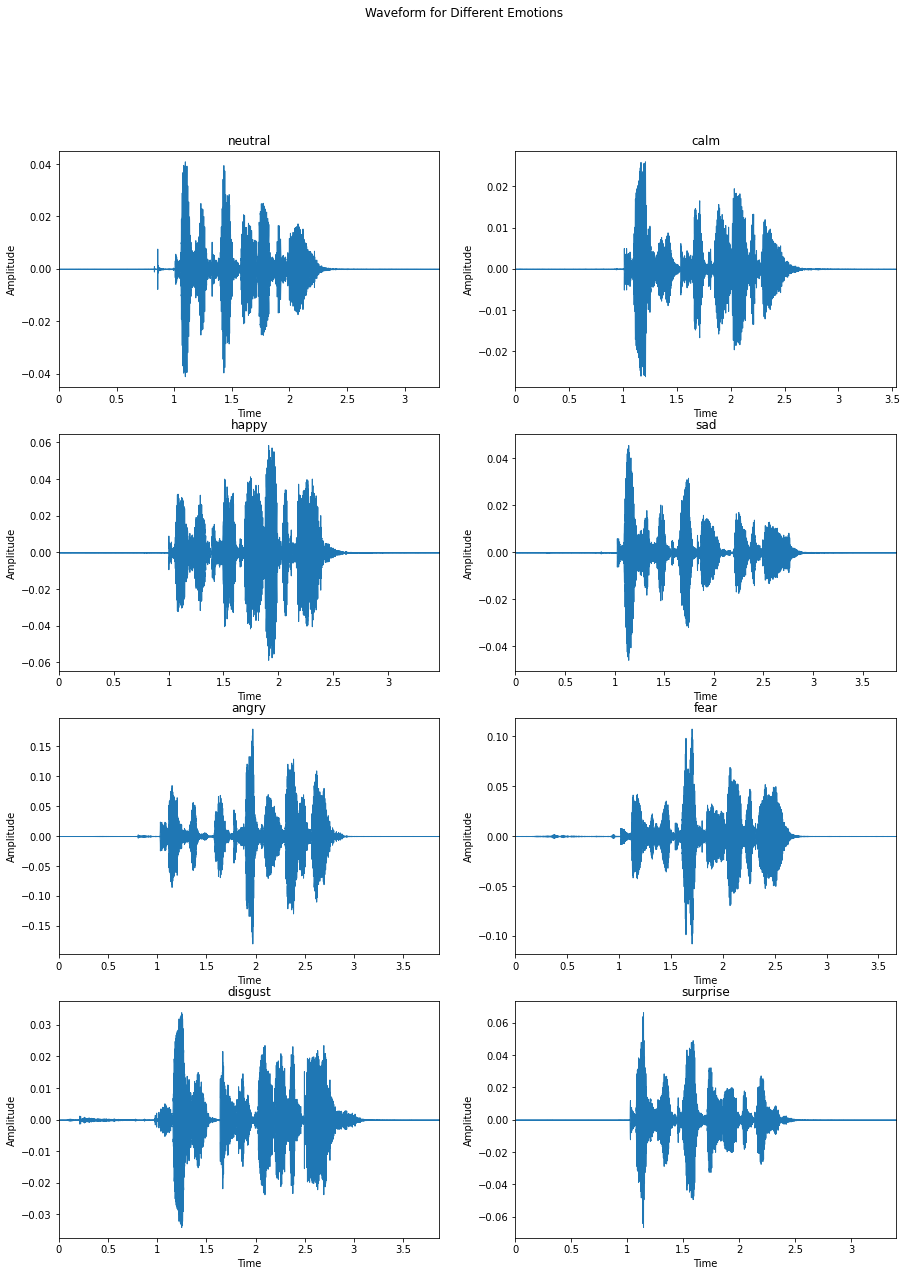

In [9]:
# Pick all the emotions
all_emotions=['neutral','calm','happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
data = []
sampling_rate = []
file_name=[]
ax = {}

fig, (ax) = plt.subplots(4, 2,figsize=(15,20))

fig.suptitle('Waveform for Different Emotions')
k=0
for i in range (4):
    for j in range (2):
        #print(RAV + 'Actor_01/03-01-0'+str(k+1)+'-01-01-01.wav')
        fr=RAV + 'Actor_01/03-01-0'+str(k+1)+'-01-01-01-01.wav'
        da, sr = librosa.load(fr)
        data.append(da)
        sampling_rate.append(sr)
        file_name.append(fr)
        ax[i][j].set_title(all_emotions[k])
        ax[i][j].set_ylabel('Amplitude')
        librosa.display.waveplot(da, sr=sr,ax=ax[i][j])
        k=k+1;

In [29]:
# 0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'
ipd.Audio(file_name[2])

### Speech Emotion Compared by Gender

../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-02.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-04-01-01-01.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-04-01-01-02.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-06-01-01-01.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-06-01-01-02.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-08-01-01-01.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-08-01-01-02.wav


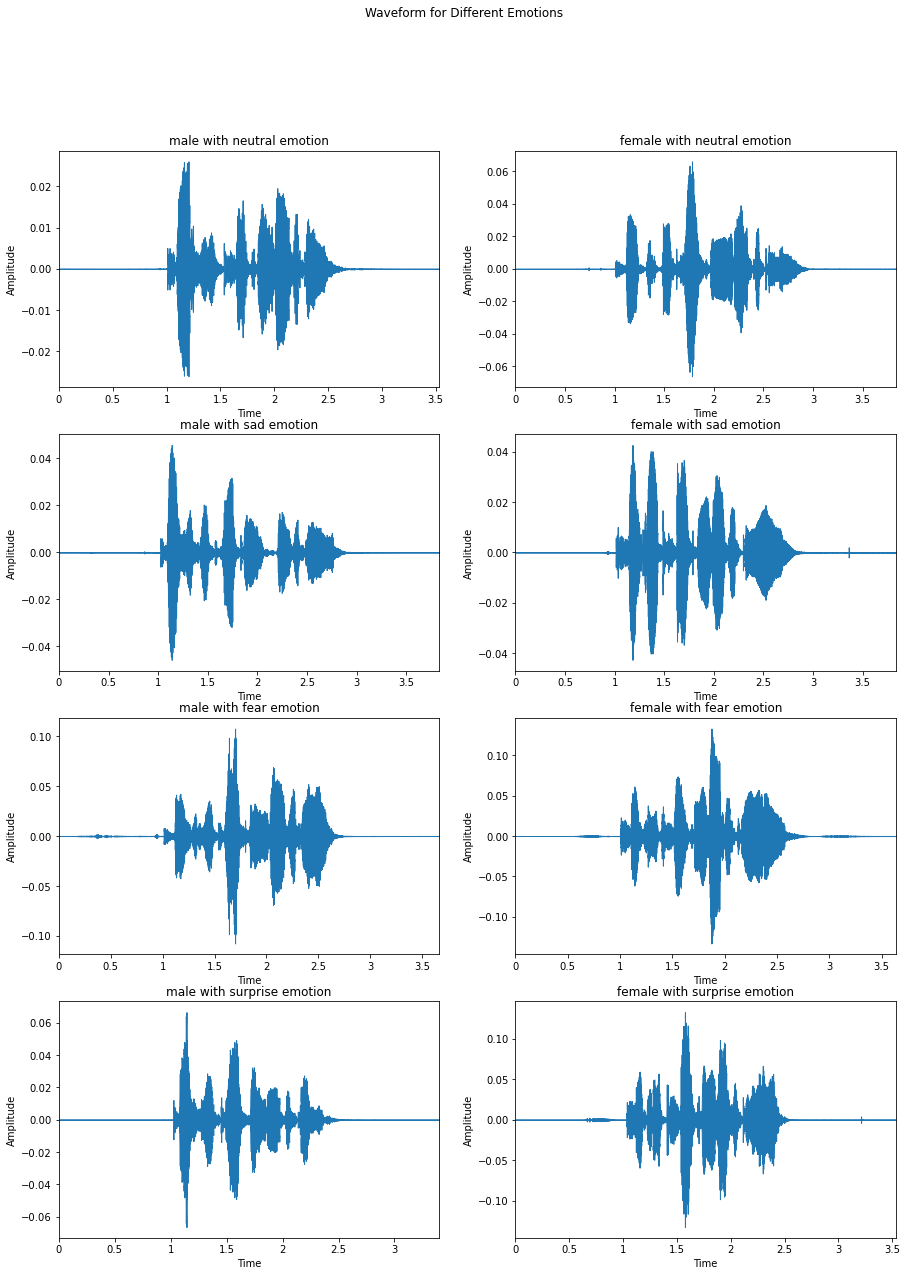

In [11]:
# Pick selected the emotions
selected_emotions=['neutral', 'sad',  'fear', 'surprise']

fig, (ax) = plt.subplots(4, 2,figsize=(15,20))
file_name_by_gender=[]
fig.suptitle('Waveform for Different Emotions')
k=2
m=0
for i in range (4):
    for j in range (2):
        
        if(j==0):
            print(RAV + 'Actor_01/03-01-0'+str(k)+'-01-01-01.wav')
            fr=RAV + 'Actor_01/03-01-0'+str(k)+'-01-01-01-01.wav'
            gender="male"
        else :
            print(RAV + 'Actor_01/03-01-0'+str(k)+'-01-01-02.wav')
            fr=RAV + 'Actor_02/03-01-0'+str(k)+'-01-01-01-02.wav' 
            gender="female"
        da, sr = librosa.load(fr)
        file_name_by_gender.append(fr)
        ax[i][j].set_title(gender+" with "+ selected_emotions[m]+" emotion")
        ax[i][j].set_ylabel('Amplitude')
        librosa.display.waveplot(da, sr=sr,ax=ax[i][j])
    k=k+2
    m=m+1

In [12]:
# 0:'male with calm', 1:'female with calm', 2:'male with sad', 3:'female with sad', 4:'male with fear', 5:'female with fear', 
# 6:'male with surprise'7:'female with surprise'
ipd.Audio(file_name_by_gender[7])

### Spectrogram View for Different Emotions

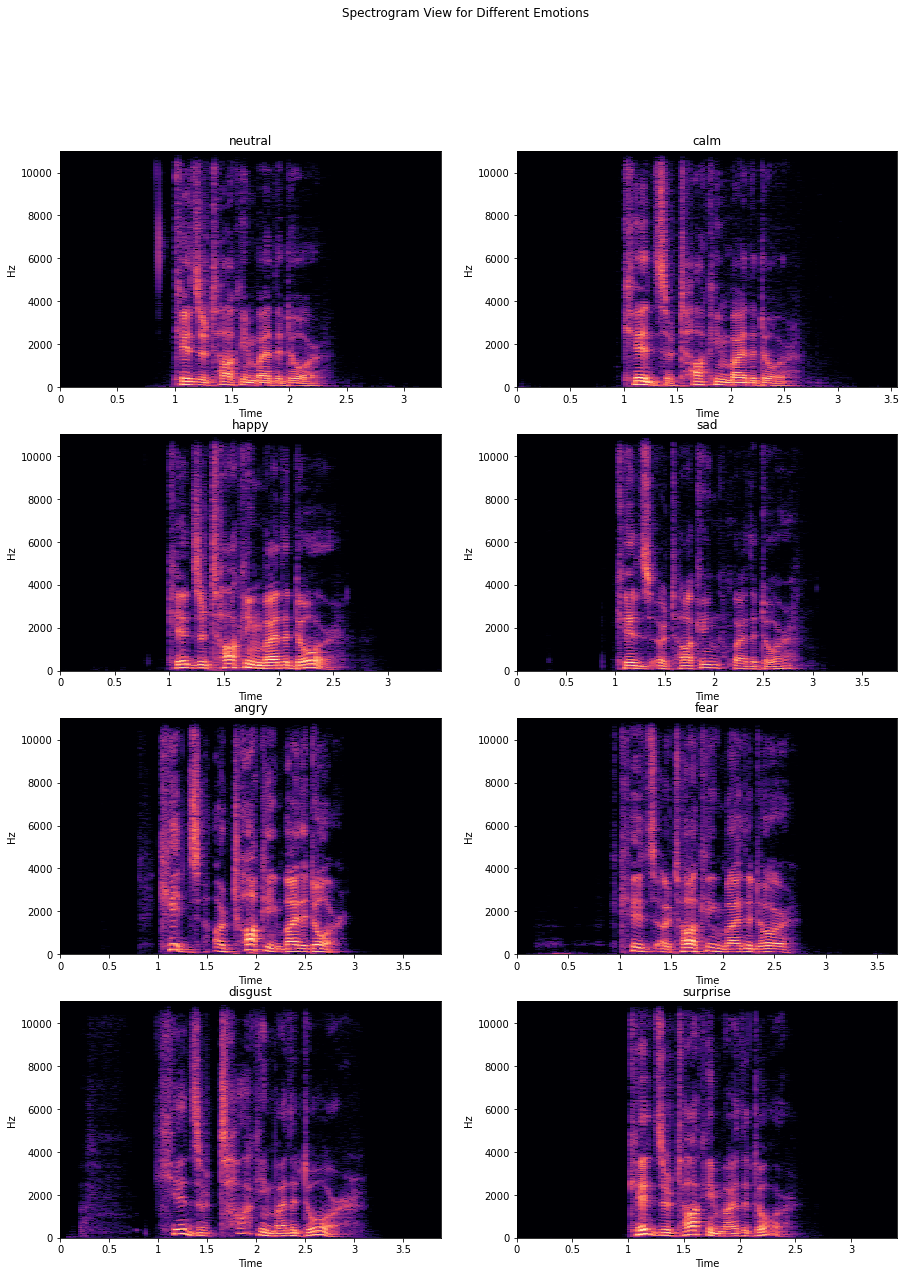

In [13]:
ax1 = {}
all_emotions=['neutral','calm','happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
fig, (ax1) = plt.subplots(4, 2,figsize=(15,20))
fig.suptitle('Spectrogram View for Different Emotions')
k=0
for i in range (4):
    for j in range (2): 
        ax1[i][j].set_title(all_emotions[k])
#         plt.colorbar()
        Xdb = librosa.amplitude_to_db(abs(librosa.stft(data[k])))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',ax=ax1[i][j])
        k=k+1;

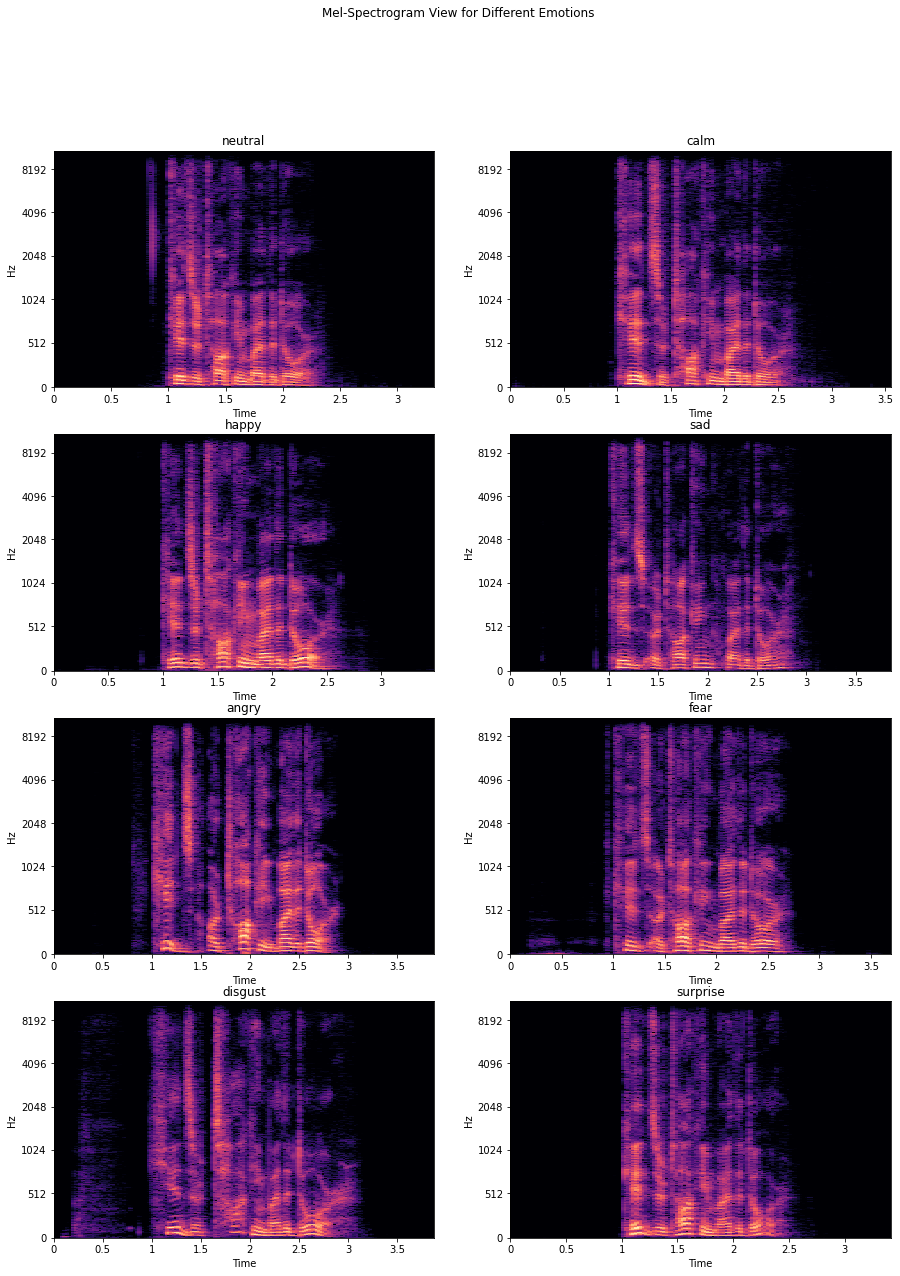

In [14]:
ax1 = {}
all_emotions=['neutral','calm','happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
fig, (ax1) = plt.subplots(4, 2,figsize=(15,20))
fig.suptitle('Mel-Spectrogram View for Different Emotions')
k=0

for i in range (4):
    for j in range (2): 
        ax1[i][j].set_title(all_emotions[k])
        Xdb = librosa.amplitude_to_db(abs(librosa.stft(data[k])))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='mel',ax=ax1[i][j])
        k=k+1;

In [15]:
df.head()

labels   source                                               path
0  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...
1  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...
2  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...
3  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...
4  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...

#### Dropping surprise emotion

As there might be some imblances for modelling later on, surprise emotions will be dropped

In [16]:
df = df[((df.labels != 'female_surprise') &( df.labels != 'male_surprise'))]

In [17]:
print(df.labels.value_counts())

male_sad          767
male_happy        767
male_disgust      767
male_fear         767
male_angry        767
male_neutral      719
female_fear       696
female_disgust    696
female_sad        696
female_angry      696
female_happy      696
female_neutral    656
Name: labels, dtype: int64


#### Saving Dataset

In [18]:
df.to_csv("../datasets/data_path.csv",index=False)

In [19]:
df.head()

labels   source                                               path
0  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...
1  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...
2  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...
3  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...
4  male_neutral  RAVDESS  ../datasets/RAVDESS/audio_speech_actors_01-24/...

In [20]:
#Emotions in the RAVDESS dataset, it will not take the neutral into the modeling process
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprise'
}
#Emotions to observe(all emotions except neutral)
observed_emotions=['neutral', 'happy', 'sad','angry','fear', 'disgust','surprise']

### Mel-Frequency Cepstrum (MFC)

Mel-Frequency Cepstrum (MFC) is a representation of the short-term power spectrum of a sound by transforming
the audio signal through a series of steps to mimic the human cochlea. The Mel scale is
important because it better approximates human-based perception of sound as opposed to linear
scales.

### Mel-Frequency Cepstral Coefficients (MFCC)

Mel-Frequency Cepstral Coefficients (MFCC) are coefficients which
capture the envelope of the short time power spectrum which will be used later in the modelling stage.

#### Exploring the MFCC features of the audio data

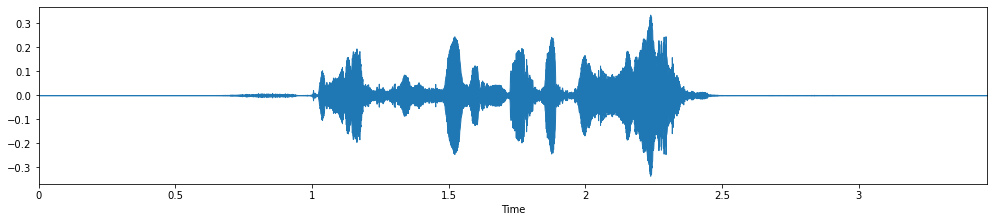

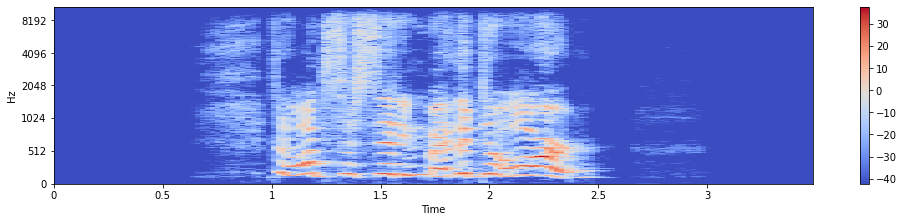

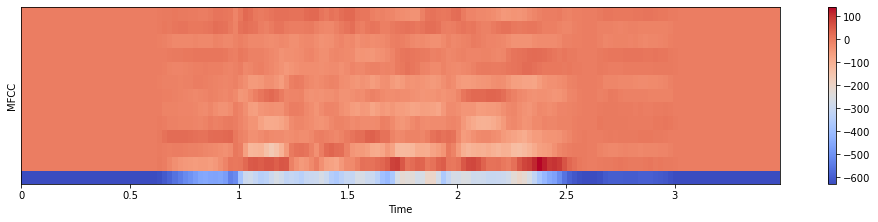

In [21]:
# Female fearful track
fname = '../datasets/RAVDESS/Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
plt.figure(figsize=(17, 15))
plt.subplot(4,1,1)
plt.title('Audio sampled Female Happy Emotion')
plt.ylabel('Amplitude')
librosa.display.waveplot(data, sr=sampling_rate)


# Spectrogram
plt.figure(figsize=(17, 15))
plt.subplot(4,1,1)
Xdb = librosa.amplitude_to_db(abs(librosa.stft(data)))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.ylabel('Hz')
plt.colorbar()

# MFCC
plt.figure(figsize=(17, 15))
plt.subplot(4,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

# Paly it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

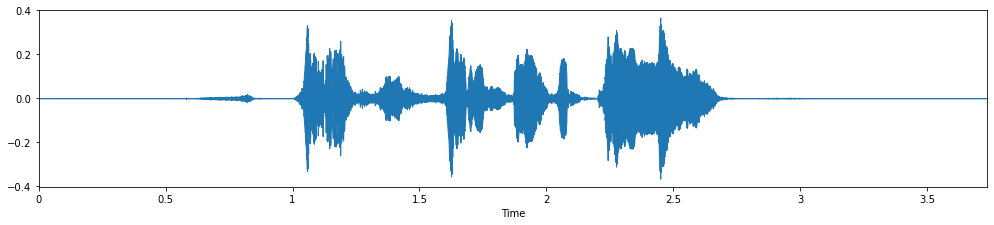

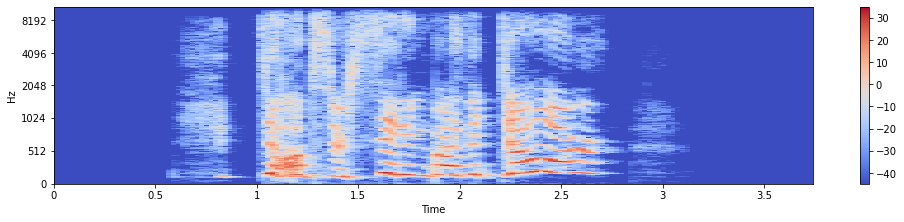

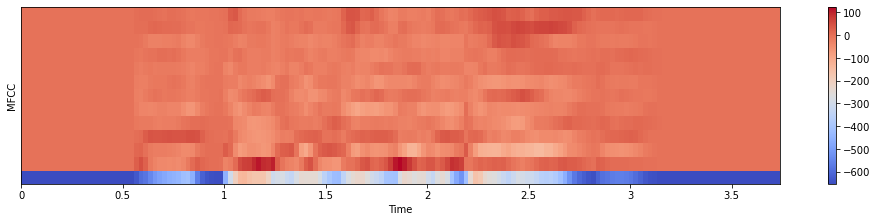

In [22]:
#  Female happy track
fname = '../datasets/RAVDESS/Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
plt.figure(figsize=(17, 15))
plt.subplot(4,1,1)
plt.title('Audio sampled Female Happy Emotion')
plt.ylabel('Amplitude')
librosa.display.waveplot(data, sr=sampling_rate)


# Spectrogram
plt.figure(figsize=(17, 15))
plt.subplot(4,1,1)
Xdb = librosa.amplitude_to_db(abs(librosa.stft(data)))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.ylabel('Hz')
plt.colorbar()

# MFCC
plt.figure(figsize=(17, 15))
plt.subplot(4,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

# Paly it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

It can be observed that MFCC features and Mel Spectograms can be represented as images, and these images can be fed to deep learning techniques such as CNN networks to classify the emotion of an audio.

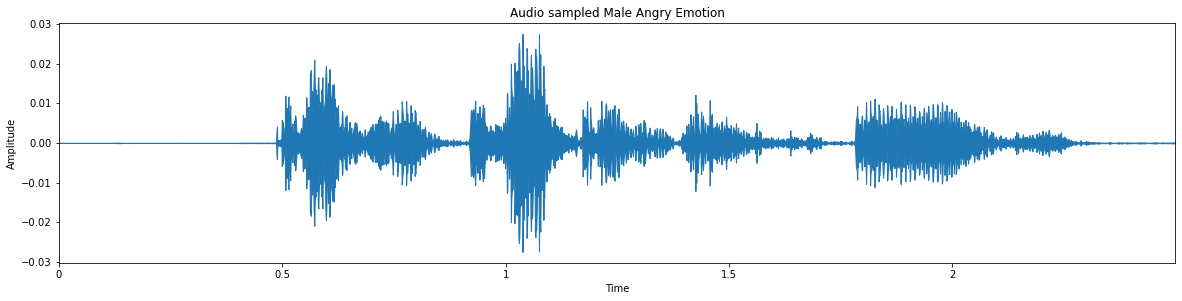

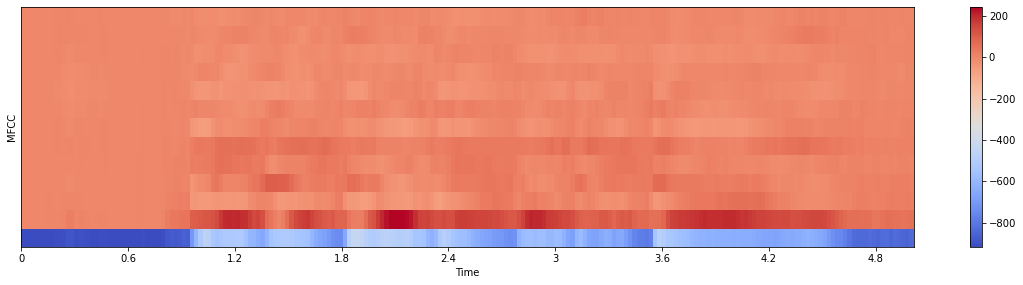

In [23]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "../datasets/RAVDESS/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled Male Angry Emotion')
plt.ylabel('Amplitude')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

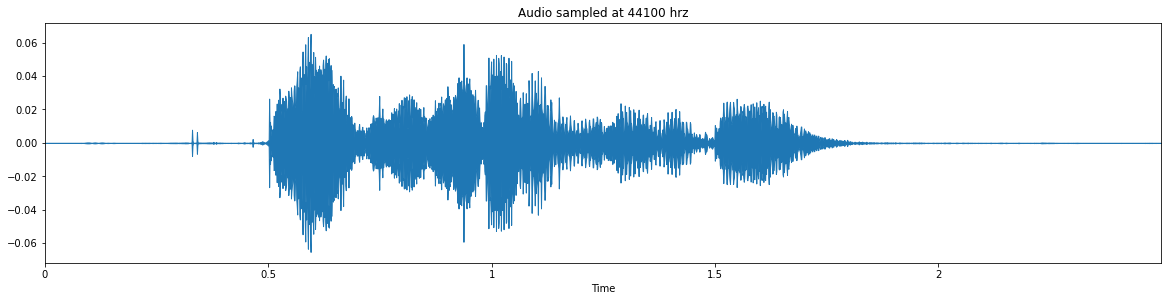

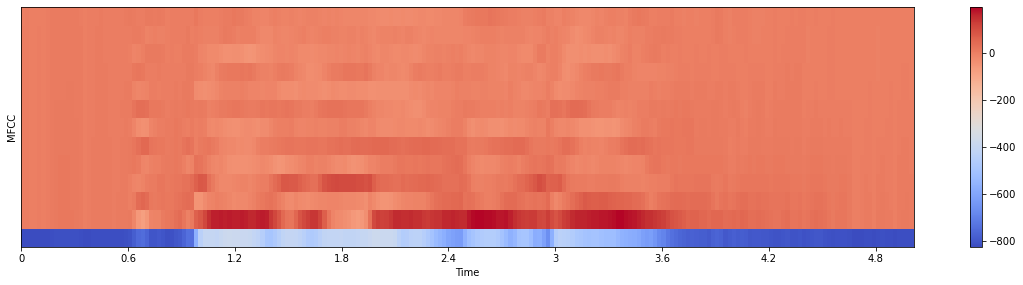

In [24]:
# Gender - Male Emotion - Happy 
path = "../datasets/RAVDESS/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

### Statistical features of MFCC

Since its observed that the output shape of the MFCC is a 2D matrix format with MFCC bands on the y-axis and time on the x-axis, this represents the MFCC bands over time. Now to look into alittle on the the mean across each band over time (row means) between a male and female on happy and angry emotions

216
216


Text(0.5, 0, 'Time')

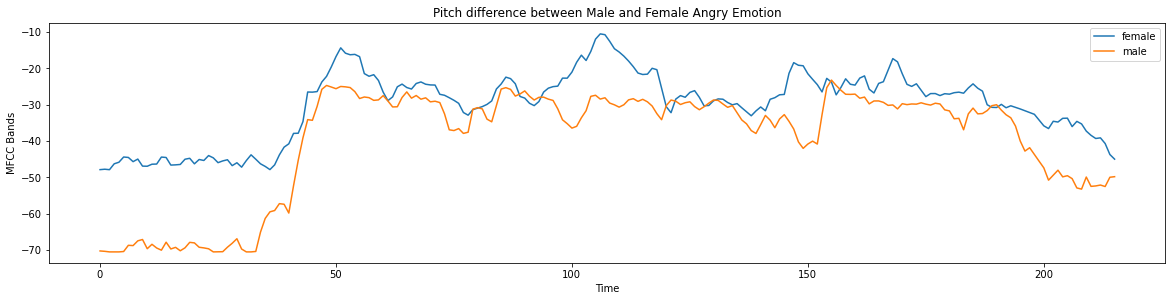

In [25]:
# Gender - Female; Emotion - Angry 
path = "../datasets/RAVDESS/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Gender - Male; Emotion - Angry 
path = "../datasets/RAVDESS/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()
plt.title('Pitch difference between Male and Female Angry Emotion')
plt.ylabel('MFCC Bands')
plt.xlabel('Time')


216
216


Text(0.5, 0, 'Time')

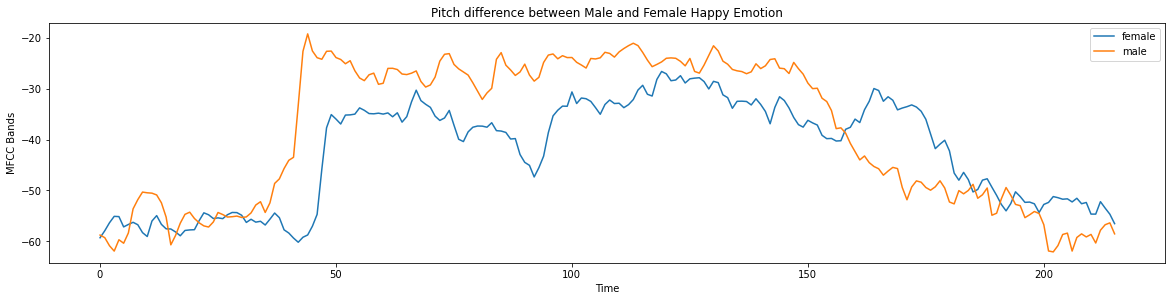

In [26]:
#RAVDESS; Gender - Female; Emotion - happy 
path = "../datasets/RAVDESS/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

#RAVDESS; Gender - Male; Emotion - happy 
path = "../datasets/RAVDESS/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()
plt.title('Pitch difference between Male and Female Happy Emotion')
plt.ylabel('MFCC Bands')
plt.xlabel('Time')

There are some distinct differences between male and female in the varying tone of pitch from the MFCC feature representation. This shows MFCC demostrates a good representation of differentiating features between gender and emotions